# CS470 Assignment 3
In this assignment, we will first design a **Markov Decision Process (MDP)** for a *gridworld* environment. Then, on top of it, we implement and run **dynamic programming (DP)** approaches. Note that you must run this file on **Google Chrome**, otherwise you may not be able to play recorded videos.

# Requirements for initialization
We will first install dependencies and declare auxiliary functions for visualization

In [6]:
#@title Run the cell below to install dependencies

  ##################################################################
  ###################                             ##################
  ###################   DO NOT MODIFY THIS CELL   ##################
  ###################                             ##################
  ##################################################################

#Install dependencies to visualize agents 
!pip install pyglet==1.5.1  &> /dev/null
!apt install -y python-opengl ffmpeg xvfb &> /dev/null
!pip install pyvirtualdisplay &> /dev/null
!pip install gym==0.23.0 &> /dev/null 
# !pip install pygame &> /dev/null
!pip install numpy &> /dev/null

# !pip install huggingface_hub &> /dev/null
!pip install pickle5 &> /dev/null
!pip install pyyaml==6.0 &> /dev/null 
!pip install imageio imageio_ffmpeg &> /dev/null

!apt-get install -y python x11-utils &> /dev/null
!pip install scikit-video ffio pyrender &> /dev/null
# !pip install tensorflow_probability==0.12.0 &> /dev/null

import numpy as np
import gym
from gym import error, spaces, utils
from gym.utils import seeding

import imageio, random, copy
import sys, time, os, base64, io
os.environ['PYOPENGL_PLATFORM'] = 'egl'

import IPython, functools, matplotlib, cv2
import matplotlib.pyplot as plt
from PIL import Image as Image
from tqdm import tqdm

from IPython.display import HTML

In [7]:
#@title Run the cell below to declare auxiliary functions

  ##################################################################
  ###################                             ##################
  ###################   DO NOT MODIFY THIS CELL   ##################
  ###################                             ##################
  ##################################################################

from IPython.display import HTML
def eval_policy(env, policy=None, num_episodes=10):
    """Evaluate a model (i.e., policy) running on the input environment"""
    # env = gym.make(env_name)
    obs = env.reset()
    prev_obs = obs
    counter = 0
    done = False
    num_runs = 0
    episode_reward = 0
    episode_rewards = []
    while num_runs < num_episodes:
        if policy is not None:
            action = policy(obs)
        else:
            action = env.action_space.sample()
        
        prev_obs = obs
        obs, reward, done, info = env.step(action)
        counter += 1
        episode_reward += reward
        if done:
            num_runs += 1
            obs = env.reset()
            episode_rewards.append(episode_reward)
            episode_reward = 0
    return episode_rewards

def save_video_of_model(env_name, model=None, suffix="", num_episodes=10):
    """
    Record a video that shows the behavior of an agent following a model 
    (i.e., policy) on the input environment
    """
    import skvideo.io
    from pyvirtualdisplay import Display
    display = Display(visible=0, size=(400, 300))
    display.start()

    env = gym.make(env_name)
    obs = env.reset()
    prev_obs = obs

    filename = env_name + suffix + ".mp4"
    output_video = skvideo.io.FFmpegWriter(filename)

    counter = 0
    done = False
    num_runs = 0
    returns = 0
    while num_runs < num_episodes:
        frame = env.render(mode='rgb_array')
        output_video.writeFrame(frame)

        if "Gridworld" in env_name:
            input_obs = obs
        else:
            raise ValueError(f"Unknown env for saving: {env_name}")

        if model is not None:
            action = model(input_obs)
        else:
            action = env.action_space.sample()


        prev_obs = obs
        obs, reward, done, info = env.step(action)
        counter += 1
        returns += reward
        if done:
            num_runs += 1
            obs = env.reset()

    output_video.close()
    print("Successfully saved {} frames into {}!".format(counter, filename))
    return filename, returns / num_runs

def play_video(filename, width=None):
    """Play the input video"""

    from base64 import b64encode
    mp4 = open(filename,'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    html = """
    <video width=400 controls>
          <source src="%s" type="video/mp4">
    </video>
    """ % data_url
    return  html


def render_value_map_with_action(env, Q, policy=None):
    '''
    Render a state (or action) value grid map.
    V[s] = max(Q[s,a])
    '''
    Q = Q.copy()
    from matplotlib.colors import LinearSegmentedColormap
    n = env.grid_map_shape[0]
    m = env.grid_map_shape[1]
    if len(np.shape(Q))>1:
        V = np.amax(Q, axis=1) 
        V = V.reshape((n,m))
    else:
        V = Q.reshape((n,m))
    import itertools
    symbol = ['.', '^','v', '<', '>']
    x = range(0, env.grid_map_shape[0]+1)
    y = range(0, env.grid_map_shape[1]+1)

    min_val = V[0,0]
    obstacles = np.zeros([n,m])
    for obstacle in env.obstacles:
        posx = obstacle // env.grid_map_shape[1]
        posy = obstacle % env.grid_map_shape[1]
        V[posx, posy] = min_val
        obstacles[posx, posy] = 1

    plt.imshow(V, cmap='jet', interpolation='nearest')
    for s in range(env.observation_space.n):
        twod_state = env.serial_to_twod(s)
        state_inds = s
        best_action = policy(s)
        plt.plot([twod_state[1]], [twod_state[0]], marker=symbol[best_action], linestyle='none', color='k')

    dark_low = ((0., 1., 1.),
            (.3, 1., 0.),
            (1., 0., 0.))
            
    cdict = {'red':  dark_low,
        'green': dark_low,
        'blue': dark_low}

    cdict3 = {'red':  dark_low,
        'green': dark_low,
        'blue': dark_low,
        'alpha': ((0.0, 0.0, 0.0),
                  (0.3, 0.0, 1.0),
                  (1.0, 1.0, 1.0))
        }
    dropout_high = LinearSegmentedColormap('Dropout', cdict3)
    plt.imshow(obstacles, cmap = dropout_high)
    plt.show()

def collect_traj(env, policy=None, num_episodes=10):
    """Collect trajectories (rollouts) following the input policy"""
    obs = env.reset()
    prev_obs = obs
    done = False
    num_runs = 0
    episode_rewards = []
    episode_reward = 0
    traj = []
    trajs = []

    while num_runs < num_episodes:
        input_obs = obs
        if policy is not None:
            action = policy(input_obs)
        else:
            action = env.action_space.sample()
        traj.append(obs)
        prev_obs = obs
        obs, reward, done, info = env.step(action)
        episode_reward += reward
        if done:
            num_runs += 1
            trajs.append(traj)
            traj = []
            obs = env.reset()

            episode_rewards.append(episode_reward)
            episode_reward = 0
    return trajs#, episode_rewards

def plot_trajs(env, trajectories):
    """Plot the input trajectories"""
    from matplotlib.colors import LinearSegmentedColormap
    n = env.grid_map_shape[0]
    m = env.grid_map_shape[1]
    V = np.zeros([n,m])
    obstacles = np.zeros([n,m])
    for obstacle in env.obstacles:
        posx = obstacle // env.grid_map_shape[1]
        posy = obstacle % env.grid_map_shape[1]
        obstacles[posx, posy] = 1
    dark_low = ((0., 1., 1.),
            (.3, 1., 0.),
            (1., 0., 0.))
    cdict = {'red':  dark_low,
        'green': dark_low,
        'blue': dark_low}
    cdict3 = {'red':  dark_low,
        'green': dark_low,
        'blue': dark_low,
        'alpha': ((0.0, 0.0, 0.0),
                  (0.3, 0.0, 1.0),
                  (1.0, 1.0, 1.0))
        }
    dropout_high = LinearSegmentedColormap('Dropout', cdict3)
    plt.imshow(obstacles, cmap = dropout_high)
    for trajectory in trajectories:
        traj_2d = np.array([ env.serial_to_twod(s) for s in trajectory ])
        y = traj_2d[:, 0]
        x = traj_2d[:, 1]
        plt.plot(x, y, alpha=0.1, color='r')
    plt.show()

# Problem 1: Markov Decision Process
In this problem, you design an MDP for a stochastic version of *grid-world* environment. You will implement *transition_model*, *compute_reward*, *is_done* and *step* functions following the rules defined in the assignment PDF.

In [8]:
  ##################################################################
  ###################                             ##################
  ###################   DO NOT MODIFY THIS CELL   ##################
  ###################                             ##################
  ##################################################################

class BaseGridEnv(gym.Env):
    metadata = {'render.modes': ['human', 'rgb_array']}
    def __init__(self, size=[8,10], start=None ,epsilon=0.05, obstacle=None):
        """
        An initialization function

        Parameters
        ----------
        size: a list of integers
            the dimension of 2D grid environment
        start: integer
            start state (i.e., location)
        epsilon: float
            the probability of taking random actions
        obstacle: 

        """
        self.grid_map_shape = [size[0], size[1]]  # The size of the map
        self.epsilon = epsilon  # action-failure probability
        self.obstacles = obstacle   # list of states stating position of the obstacles
        
        ''' set observation space and action space '''
        self.observation_space = spaces.Discrete( size[0] * size[1])
        self.action_space = spaces.Discrete( 5 )
    
        self.start_state = 0
        self.terminal_state = size[0] * size[1] - 1

    def serial_to_twod(self, ind):
        """Convert a serialized state number to a 2D map's state coordinate"""
        return np.array( [ ind // self.grid_map_shape[1], ind % self.grid_map_shape[1]])

    def twod_to_serial(self, twod):
        """Convert a 2D map's state coordinate to a serialized state number"""
        return np.array( twod[0]* self.grid_map_shape[1] + twod[1])

    def reset(self):
        """Rest the environment by initializaing the start state """
        self.observation = self.start_state
        return self.observation

    def render(self, mode='human', close=False):
        """Render the agent state"""
        pixel_size = 20
        img = np.zeros([ pixel_size * self.grid_map_shape[0], pixel_size * self.grid_map_shape[1],3])
        for obstacle in self.obstacles:
          pos_x, pos_y = self.serial_to_twod(obstacle)
          img[pixel_size*pos_x: pixel_size*(1+pos_x), pixel_size*pos_y: pixel_size*(1+pos_y)] += [255,0,0]
        agent_state = self.serial_to_twod(self.observation)   
        agent_target_state = self.serial_to_twod(self.terminal_state)
        img[pixel_size*agent_state[0]: pixel_size*(1+agent_state[0]), pixel_size*agent_state[1]: pixel_size*(1+agent_state[1])] += [0,0,255]
        img[pixel_size*agent_target_state[0]: pixel_size*(1+agent_target_state[0]), pixel_size*agent_target_state[1]: pixel_size*(1+agent_target_state[1])] += [0,255,0]
        if mode == 'human':
          fig = plt.figure(0)
          plt.clf()
          plt.imshow(img, cmap='gray')
          fig.canvas.draw()
          plt.pause(0.01)
        if mode == 'rgb_array':
          return img
        return 

    def _close_env(self):
        """Close the environment screen"""
        plt.close(1)
        return


In [9]:
class GridEnv(BaseGridEnv):
    """
    A grid-world environment.
    """
    def transition_model(self, state, action):
        """
        A transition model that return a list of probabilities of transitions
        to next states when the agent select 'action' at the 'state': T(s' | s,a)

        In our envrionemnt, if the state is in obstacles or in a goal, 
        it will stay in its state at any action

        Parameters
        ----------        
        state: integer
            a serialized state index
        action: integer
            action index        

        Returns
        -------  
        probs: numpy array with a length of {size of state space}
            probabilities of transition to the next_state ...   


        """
        if not isinstance(state, int):                                                     ####################################### the agent should not leave an obstacle or terminal state
            state = state.item()
        


        # the transition probabilities to the next states
        probs = np.zeros(self.observation_space.n)

        # Left top is [0,0], 
        action_pos_dict = {0: [0,0], 1:[-1, 0], 2:[1,0], 3:[0,-1], 4:[0,1]}

        
        state_twod = np.array(self.serial_to_twod(state))
        
        #print(state_twod)
        [h, w] = self.grid_map_shape

        #state_domain = []

        ###################################################################
        #####################   PLACE YOUR CODE HERE   ####################
        ###                                                             ###
        ### Instruction                                                 ###
        ### -----------                                                 ###
        ### - You have to fill out the "probs" variable following the   ###
        ###   the assignment-problem 1's transition model rules         ###        
        ### - Hint: you have to find the next state based on the        ###
        ###         available action at the current state               ###
        ###
        ### Example
        ### --------
        ### After some initializations...
        ### for action in availabe actions:
        ###     find a next state
        ###     fill out probs[next state]

        # First we check whethere or not the agent is at terminal location
        # If it it at terminal location we set the probability to 1
        if state == self.terminal_state or state in self.obstacles:
          probs[state] = 1

        # If we are not at a terminal location then we  will find the candidate arrays that the agent might move to
        else:

          for i in range(len(action_pos_dict)):    # Here, the list inside the dictionary action_pos_dict was converted to np arrray for ease of calculation
            action2 = np.array(action_pos_dict[i]) # returns a numpy version of the action array [0, -1]
            
            cand = action2 + state_twod             # cand is a candidate numpy array for our agent to move onto
            if np.sum(cand < 0) > 0:                # if cand has negative index, or too large of an index, it means it is out of the world we were given, so we set it to the current location
              cand = state_twod             
            if cand[0] > h - 1 or cand[1] > w - 1:
              cand = state_twod
        
            serial = self.twod_to_serial(cand)
            
            if i == action:                           # for the action, that was deliberately chosen we have 1 - epsilon probability
              probs[serial] += 1 - self.epsilon
            else:
              probs[serial] += self.epsilon/(len(action_pos_dict)-1)             # for the rest of possible actions we distribute epsilon uniformly
        ###        
        ###                                                             ###
        ###                                                             ###
        ###################################################################
        ###################################################################

        return probs


    def compute_reward(self, state, action, next_state):
        """
        A reward function that returns the total reward after selecting 'action'
        at the 'state'. In this environment, 
        (a) If it reaches a goal state, it terminates returning a reward of +10
        (b) If it reaches an obstacle, it terminates returning a penalty of -5
        (c) For any action, it add a step penalty of -0.1

        Parameters
        ----------        
        state: integer
            a serialized state index
        action: integer
            action index         
        next_state: integer
            a serialized state index

        Returns
        -------  
        reward: float
            a total reward value
        """

        reward = 0



        

        ###################################################################
        #####################   PLACE YOUR CODE HERE   ####################
        ###                                                             ###
        ### Instruction                                                 ###
        ### -----------                                                 ###
        ### - fill out the reward variable                              ###

        if state == self.terminal_state:                # reward should be 10 or -5 for terminal states and -0.1 for every step/action
          reward += 10
        elif state in self.obstacles:
          reward -= 5
        reward -= 0.1


        ###                                                             ###
        ###                                                             ###
        ###                                                             ###
        ###################################################################
        ###################################################################
        return reward
    
    def is_done(self, state, action, next_state):
        """
        Return True when the agent is in a terminal state or obstacles, 
        otherwise return False

        Parameters
        ----------        
        state: integer
            a serialized state index
        action: integer
            action index         
        next_state: integer
            a serialized state index

        Returns
        -------  
        done: Bool
            the result of termination or collision
        """
        done = None

        

        ###################################################################
        #####################   PLACE YOUR CODE HERE   ####################
        ###                                                             ###
        ### Instruction                                                 ###
        ### -----------                                                 ###
        ### - fill out the "done" variable                              ###

        if state == self.terminal_state:
          done = True
        elif state in self.obstacles:
          done = True
        else:
          done = False

        ###                                                             ###
        ###################################################################
        ###################################################################

        return done 

    def step(self, action):
        """
        A step function that applies the input action to the environment.

        Parameters
        ----------        
        action: integer
            action index         

        Returns
        -------  
        observation: integer
            the outcome of the given action (i.e., next state)... s' ~ T(s'|s,a)
        reward: float
            the reward that would get for ... r(s, a, s')
        done: Bool
            the result signal of termination or collision
        info: Dictionary
            Information dictionary containing miscellaneous information...
            (Do not need to implement info)

        """
        done = False
        action = int(action)
        
        probs = self.transition_model(self.observation, action)

        
        

        ###################################################################
        #####################   PLACE YOUR CODE HERE   ####################
        ###                                                             ###
        ### Instruction                                                 ###
        ### -----------                                                 ###
        ### - sample the next state considring the transition model     ###
        ### - then, compute "reward" and "done"                         ###
        ###   next_state = ...                                          ###
        ###
        ### Example                                                     ###
        ### -----------                                                 ###
        ### next state = ?
        ### self.observation = ?
        ### reward = self.compute_reward(?, action, self.observation)   ###
        ### done = self.is_done(?, action, self.observation)            ###
        states = list(range(self.grid_map_shape[0] * self.grid_map_shape[1]))
        state_index = np.random.choice(states, p=probs)                         # this numpy function allows us to choose from an array with 
        reward = self.compute_reward( self.observation, action, state_index)    # uniform distribution by providing the probabilities in the argument p
        done = self.is_done(self.observation, action, state_index)
        self.observation = state_index #
        
        ###                                                             ###
        ###################################################################
        ###################################################################

        return (self.observation, reward, done, {})

  ##################################################################
  ###################                             ##################
  ###################  DO NOT MODIFY CODE BELOW   #################
  ###################                             ##################
  ##################################################################

from gym import register
if 'Gridworld-v0' in gym.envs.registration.registry.env_specs:
    del gym.envs.registration.registry.env_specs['Gridworld-v0']
register(
    id='Gridworld-v0',
    entry_point=GridEnv,
    max_episode_steps=30,
    reward_threshold=100,
    kwargs={'epsilon':0.05, 'size':[8, 10], 'obstacle':[32, 43, 62, 63, 44, 35, 26, 58, 49, 41, 57, 61, 31]}
)
env = gym.make("Gridworld-v0")



##(a) Transition model / dynamics

Following the problem description on the assignment PDF, implement the transition_model. After implementation, please run the cell below.

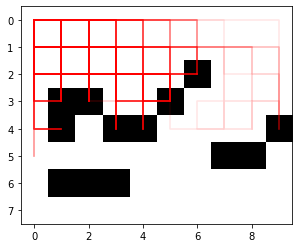

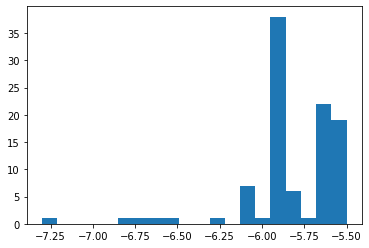

In [10]:
def dummy_policy(state):
    """A dummy random policy"""
    if state > 40:
        return np.random.choice([1, 3], 1).item()
    else:
        return np.random.choice([2, 4], 1).item()

# Plot the distribution of the collected trajectories
trajs = collect_traj(env, policy=dummy_policy, num_episodes=300)
plot_trajs(env, trajs)

# Plot the histogram of returns after running a dummy policy
returns = eval_policy(env, policy=dummy_policy, num_episodes=100)
plt.hist(returns, bins=20)
plt.show()

Add your code to print out the transition model at a specific coordinate with an action you want. \\
1) print out the transition probabilities to all the next states given a current state $[3,3]$ and a selected action "Up":

In [11]:
a = env.transition_model(env.twod_to_serial([3,3]), 1)
print(a)


[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.95   0.     0.     0.     0.     0.     0.
 0.     0.     0.0125 0.0125 0.0125 0.     0.     0.     0.     0.
 0.     0.     0.     0.0125 0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.    ]


2) Print out the transition probabilities to all the next states given a current state [7,4] and a selected action "Down":

In [13]:
a  = env.transition_model(env.twod_to_serial([7,4]), 2)
print(a)



[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.0125 0.     0.     0.     0.     0.
 0.     0.     0.     0.0125 0.9625 0.0125 0.     0.     0.     0.    ]


3) print out the transition probabilities to all the next states given a current state $[4,9]$ and a selected action "Down":

In [14]:
a = env.transition_model(env.twod_to_serial([4,9]), 2)
a.reshape(8, 10)
print(a)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]


## (b) Environmental Interactions


Following the problem description on the assignment PDF, implement ***compute_reward***, ***is_done***, and ***step*** functions. Here, 

*   ***is_done*** function determines wether the given next_state terminates the episode or not. 
*   ***step*** function updates its *self.observation* to the next state.

After implementation, please run the cell below to see the histogram of returns.





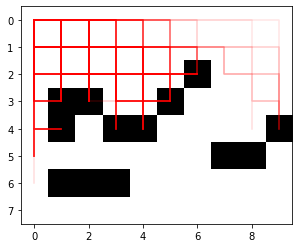

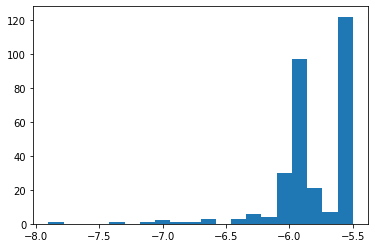

In [ ]:
from gym import register
if 'Gridworld-v0' in gym.envs.registration.registry.env_specs:
  del gym.envs.registration.registry.env_specs['Gridworld-v0']
register(
    id='Gridworld-v0',
    entry_point=GridEnv,
    max_episode_steps=30,
    reward_threshold=100,
    kwargs={'epsilon':0.05, 'size':[8, 10], 'obstacle':[32, 43, 62, 63, 44, 35, 26, 58, 49,41,57,61,31]}
)
env = gym.make("Gridworld-v0")

trajs = collect_traj(env, policy=dummy_policy, num_episodes=300)
plot_trajs(env, trajs)

returns = eval_policy(env, policy=dummy_policy, num_episodes=300)
plt.hist(returns, bins=20)
plt.show()

# Problem 2: Dynamic Programming (DP)

Great! You can now run an agent to test your MDP implementation.

In [ ]:
# You can save a video of 10 episodes that visualizes the average of the returns 
# based on the current (dummy) policy.
saved_run, returns = save_video_of_model("Gridworld-v0", model=dummy_policy, num_episodes=10)
HTML(play_video(saved_run))

Successfully saved 87 frames into Gridworld-v0.mp4!


## (2.1) Value Iteration 
You implement and analyze the value iteration (VI) algorithm filling out ***value_iteration*** and ***get_action*** functions. Please, check the assignment PDF for more details. 

* Hint: you may need to implement your own ***arg_max*** function




In [ ]:
class ValueIteration:
    """
    Value Iteration
    """
    def __init__(self, env,  theta=0.00001, discount_factor=0.9):
        """
        Initialize the VI class

        Parameters
        ----------        
        env: object
            an OpenAI Gym compatible environment
        theta: float
            a max error (termination) threshold 
        discount_factor: float
            discount factor (i.e., gamma)

        Returns
        -------  
        probs: numpy array with a length of {size of state space}
            probabilities of transition to the next_state ...                    
        """      
        self.env = env
        self.V = np.zeros(env.observation_space.n)
        self.discount_factor = discount_factor
        self.theta= theta   # Maximum error thresold value
    
    def value_iteration(self):
        """
        A value iteration function. Until the error bound reaches the threshold 
        (theta), The value table is updated by the Dynamic Programming 
        (refer to the lecture)
        """

        errors = []
        episode_rewards = []
        while True:
            max_error = 0
            for state in range(env.observation_space.n):


            ###################################################################
            #####################   PLACE YOUR CODE HERE   ####################
            ###                                                             ###
            ### Instruction                                                 ###
            ### -----------                                                 ###
            ### Fill out self.V by using the VI algorithm                   ###      
            ###
            ### Example                                                     ###
            ### -----------                                                 ###
            ### Initializations
            ### For a in available actions
            ###   For s' in available next states
            ###     Compute reward(s,a,s'), etc
            ###     Compute action value 
            ### Fill out "self.V" at the current state using the action values

              # to compute the value we need the current state
              state_value = self.V[state]
              possible_outputs = np.zeros(env.action_space.n) # we compute the sum for each action and choose the best action
              
              for i in range(env.action_space.n):
                probs = env.transition_model(state, i)
                next_state = np.arange(env.observation_space.n)    # all the states are viable for being the next state
                for n_state in next_state:
                  rewards = env.compute_reward(state, i, n_state)
                  possible_outputs[i] += probs[n_state]*(rewards + self.discount_factor *self.V[n_state]) # we multiply with the probabilities to find expectations
                  
              
              self.V[state] = np.max(possible_outputs)    # we update the value of a state to the maximum of the value from each action
              max_error = max(max_error, abs(self.V[state] - state_value))   

            ###                                                             ###
            ###################################################################
            ###################################################################
            errors.append(max_error)
            mean_ep_reward = np.mean( eval_policy(env, policy=self.get_action, num_episodes=10))
            episode_rewards.append(mean_ep_reward)

            if max_error < self.theta:
                break
        return episode_rewards, errors

    def get_action(self, state):
        """
        Return the best action. 
        HINT: how do you handle if there are multiple actions with the highest value? #########################################

        Parameters
        ----------        
        state: integer
            a serialized state index

        Returns
        -------  
        action: integer
            an action index
        """



        """"""



        ###################################################################
        #####################   PLACE YOUR CODE HERE   ####################
        ###                                                             ###
        ### Instruction                                                 ###
        ### -----------                                                 ###
        ### Find the best "action" that maximize Q value                ###      
        ###                                                             ###  
        ### Example                                                     ###
        ### -----------                                                 ###
        ### Compute Q values when you apply each action                 ###
        ### For a in available actions
        ###   For s' in next states
        ###     Q[a] = ?  
        ###
        ### action = ?
        action = None

        values = self.V
        possible_outputs = np.zeros(env.action_space.n)           # there are 5 possible output actions
    
        for i in range(env.action_space.n):
          probs = env.transition_model(state, i)                  # we get the transition probability given state and action i
          next_state = np.arange(env.observation_space.n)         # then for each state we compute the expected value for the next state
          for n_state in next_state:
            rewards = env.compute_reward(state, i, n_state)
            possible_outputs[i] += probs[n_state]*(rewards + self.discount_factor * self.V[n_state])
        
        action = np.argmax(possible_outputs)                      # we set the action to the action that results with maximum sum
        
        ###                                                             ###
        ###################################################################
        ###################################################################
        return action

After implementation, you can check your implementation with the following code.

In [ ]:
##### Codes for the running the policy (Do not Modify) #####
env = gym.make("Gridworld-v0")
env.epsilon = 0.05
vi = ValueIteration(env, discount_factor=0.9)
ep_rews, errors = vi.value_iteration()

You can check the state values of the first 10 states:

In [ ]:
# the values of the first 10 states of the gridworld environment
print(vi.V[:10])

[12.74268488 12.71299997 14.30472242 16.10238558 18.11066683 20.35399326
 22.85975614 25.65825242 23.63684394 21.12189328]


You can also overlay the best action at each state and plot the distribution of trajectories produced by the trained VI policy:

Successfully saved 183 frames into Gridworld-v0.mp4!


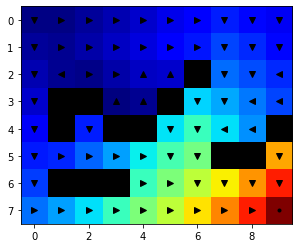

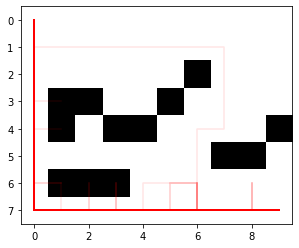

In [ ]:
## 1. Visualize the policy with the video and trajectories plot
saved_run, _ = save_video_of_model("Gridworld-v0", vi.get_action)
render_value_map_with_action(env, vi.V, vi.get_action)
HTML(play_video(saved_run))
trajs = collect_traj(env, policy=vi.get_action, num_episodes=100)
plot_trajs(env, trajs)

You can also plot the expected returns and errors with respect to the number of iterations until convergence:

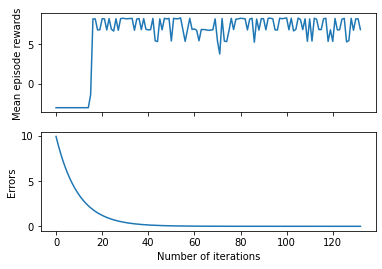

In [ ]:
## Plot error and mean episodic rewards per iterations
ax = plt.subplot(2,1,1)
ax.plot(ep_rews)
bx = plt.subplot(2,1,2)
bx.plot(errors)
ax.set_ylabel('Mean episode rewards')
ax.ticklabel_format(axis='x', style='sci', scilimits=(0,0))
bx.set_xlabel('Number of iterations')
bx.set_ylabel('Errors')
labels = [item.get_text() for item in ax.get_xticklabels()]
empty_string_labels = ['']*len(labels)
ax.set_xticklabels(empty_string_labels)

plt.show()

## (2.2) Comparison under different transition models

Here, you need to vary $\epsilon$. Get the necessary results when $\epsilon=0.05$:

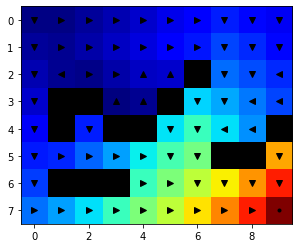

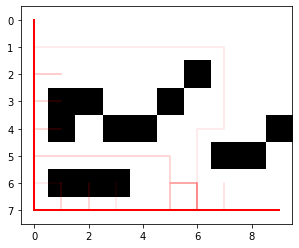

In [100]:
from gym import register
if 'Gridworld-v0' in gym.envs.registration.registry.env_specs:
    del gym.envs.registration.registry.env_specs['Gridworld-v0']
register(
    id='Gridworld-v0',
    entry_point=GridEnv,
    max_episode_steps=30,
    reward_threshold=100,
    kwargs={'epsilon':0.05, 'size':[8, 10], 'obstacle':[32, 43, 62, 63, 44, 35, 26, 58, 49,41,57,61,31]}
)                                                       
env = gym.make("Gridworld-v0")


vi = ValueIteration(env, discount_factor=0.9)
ep_rews_005, errors = vi.value_iteration()

###################################################################

env.epsilon = 0.05
render_value_map_with_action(env, vi.V, vi.get_action)
trajs = collect_traj(env, policy=vi.get_action, num_episodes=100)
plot_trajs(env, trajs)

###################################################################
#####################   PLACE YOUR CODE HERE   ####################
###                                                             ###
### 1. plot the expected return                                 ###
### 2. Overlay the best action                                  ###
### 3. Plot the distribution of trajectories                    ###

###################################################################

Get the necessary results when $\epsilon=0.2$:

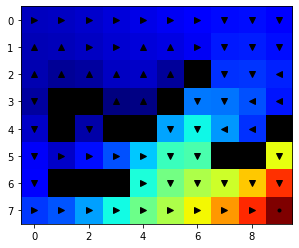

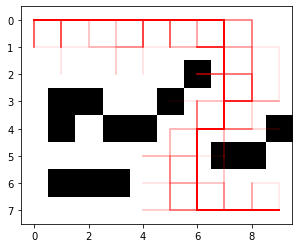

In [ ]:
from gym import register
if 'Gridworld-v0' in gym.envs.registration.registry.env_specs:
    del gym.envs.registration.registry.env_specs['Gridworld-v0']
register(
    id='Gridworld-v0',
    entry_point=GridEnv,
    max_episode_steps=30,
    reward_threshold=100,
    kwargs={'epsilon':0.2, 'size':[8, 10], 'obstacle':[32, 43, 62, 63, 44, 35, 26, 58, 49,41,57,61,31]}
)                                                
env = gym.make("Gridworld-v0")

vi = ValueIteration(env, discount_factor=0.9)
ep_rews_02, errors_02 = vi.value_iteration()
###################################################################

env.epsilon = 0.2
render_value_map_with_action(env, vi.V, vi.get_action)
trajs = collect_traj(env, policy=vi.get_action, num_episodes=100)
plot_trajs(env, trajs)

###################################################################
#####################   PLACE YOUR CODE HERE   ####################
###                                                             ###
### 1. plot the expected return                                 ###
### 2. Overlay the best action                                  ###
### 3. Plot the distribution of trajectories                    ###

###################################################################

Text(0.5, 1.0, 'Expected returns per E value')

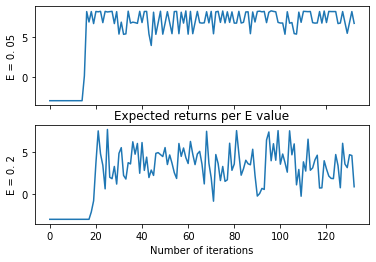

In [101]:
## Plot error and mean episodic rewards per iterations
ax = plt.subplot(2,1,1)
ax.plot(ep_rews_005)
bx = plt.subplot(2,1,2)
bx.plot(ep_rews_02)
ax.set_ylabel('E = 0. 05')
ax.ticklabel_format(axis='x', style='sci', scilimits=(0,0))
bx.set_xlabel('Number of iterations')
bx.set_ylabel('E = 0. 2')
labels = [item.get_text() for item in ax.get_xticklabels()]
empty_string_labels = ['']*len(labels)
ax.set_xticklabels(empty_string_labels)
plt.title("Expected returns per E value")